In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

In [ ]:
#importing dataset
dataset_directory = os.listdir('/content/drive/MyDrive/Plant_Village_data/PotatoLeafImage_data')
for filenames in dataset_directory:
    print(filenames)

Potato___Early_blight
Potato___Late_blight
Potato___healthy


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import cv2

In [ ]:
#Global initialization of some imp variables
Image_Size = 256
Batch_Size = 32
Channels = 3

In [ ]:
dataset_directory = '/content/drive/MyDrive/Plant_Village_data/PotatoLeafImage_data'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_directory,  # this should be a string, not a list
    batch_size=Batch_Size,
    image_size=(Image_Size, Image_Size),
    shuffle=True
)

Found 2152 files belonging to 3 classes.


In [ ]:
#Folders(classes) in 'Dataset' directory
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset) # Number of Batches = (total number of files belonging to all classes / Batch_Size)

68

In [ ]:
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 10)

    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_data, val_data, test_data = split_dataset(dataset)

In [ ]:
print("Size of Data is :{0} \nBatch size of Training Data is :{1}\nBatch size of Validation Data is :{2} \nBatch size of Testing Data is :{3} " .format(len(dataset), len(train_data), len(val_data), len(test_data)))

Size of Data is :68 
Batch size of Training Data is :54
Batch size of Validation Data is :6 
Batch size of Testing Data is :8 


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# Image Preprocessing : Rescaling and Resizing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size, Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
# Define the data augmentation in a Sequential model
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
  layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest'),
  layers.experimental.preprocessing.RandomContrast(factor=0.2)
])



In [ ]:
# Apply Data Augmentation on Training Images
train_ds = train_data.cache().shuffle(1000).map(
  lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

In [ ]:
# Model at Batch Size 32 and Learning Rate 0.0001
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
model_32_DR4_0001 = Sequential([
    resize_and_rescale,
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(3, activation='softmax')
])
model_32_DR4_0001.build(input_shape = input_shape)
model_32_DR4_0001.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
learning_rate = 0.0001
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_32_DR4_0001.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [ ]:
#Fit the model with training data and also pass validation data
history_32_DR4_0001 = model_32_DR4_0001.fit(
train_ds, epochs = 200, batch_size = Batch_Size, verbose = 1, validation_data = val_ds)

Epoch 1/200
54/54 [==============================] - 185s 652ms/step - loss: 1.0014 - accuracy: 0.4466 - val_loss: 0.8990 - val_accuracy: 0.5052
Epoch 2/200
54/54 [==============================] - 34s 637ms/step - loss: 0.9328 - accuracy: 0.4707 - val_loss: 0.8698 - val_accuracy: 0.5052
Epoch 3/200
54/54 [==============================] - 34s 632ms/step - loss: 0.9232 - accuracy: 0.4783 - val_loss: 0.8653 - val_accuracy: 0.5156
Epoch 4/200
54/54 [==============================] - 34s 635ms/step - loss: 0.9086 - accuracy: 0.4965 - val_loss: 0.8481 - val_accuracy: 0.5052
Epoch 5/200
54/54 [==============================] - 34s 633ms/step - loss: 0.9091 - accuracy: 0.5000 - val_loss: 0.8359 - val_accuracy: 0.5052
Epoch 6/200
54/54 [==============================] - 34s 628ms/step - loss: 0.9017 - accuracy: 0.5135 - val_loss: 0.8428 - val_accuracy: 0.7292
Epoch 7/200
54/54 [==============================] - 34s 634ms/step - loss: 0.8771 - accuracy: 0.5528 - val_loss: 0.8054 - val_accuracy

In [ ]:
# Getting the model history to analyse
train_loss = history_32_DR4_0001.history['loss']
train_acc = history_32_DR4_0001.history['accuracy']

val_loss = history_32_DR4_0001.history['val_loss']
val_acc = history_32_DR4_0001.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

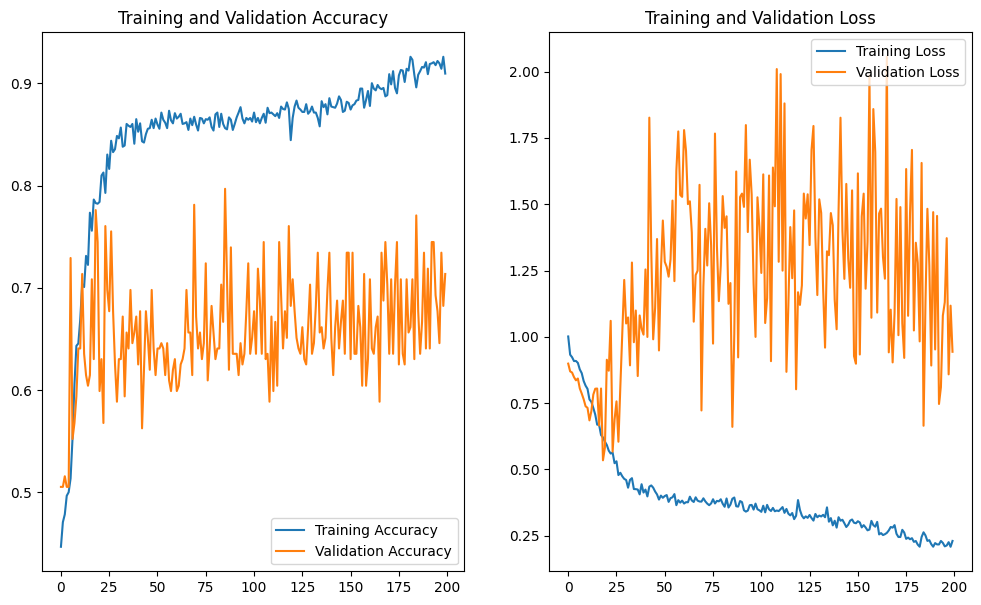

In [ ]:
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_acc)), train_acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
# Model at Batch Size 32 and Learning Rate 0.001
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
model1_32_DR4_001 = Sequential([
    resize_and_rescale,
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(3, activation='softmax')
])
model1_32_DR4_001.build(input_shape = input_shape)
model1_32_DR4_001.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
learning_rate = 0.001
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model1_32_DR4_001.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [ ]:
#Fit the model with training data and also pass validation data
history1_32_DR4_001 = model1_32_DR4_001.fit(
train_ds, epochs = 200, batch_size = Batch_Size, verbose = 1, validation_data = val_ds)

Epoch 1/200
54/54 [==============================] - 190s 635ms/step - loss: 0.9228 - accuracy: 0.4800 - val_loss: 0.8329 - val_accuracy: 0.5990
Epoch 2/200
54/54 [==============================] - 33s 616ms/step - loss: 0.7778 - accuracy: 0.6608 - val_loss: 0.7633 - val_accuracy: 0.6823
Epoch 3/200
54/54 [==============================] - 34s 623ms/step - loss: 0.6628 - accuracy: 0.7447 - val_loss: 0.8495 - val_accuracy: 0.6771
Epoch 4/200
54/54 [==============================] - 33s 615ms/step - loss: 0.6351 - accuracy: 0.7518 - val_loss: 0.7058 - val_accuracy: 0.7344
Epoch 5/200
54/54 [==============================] - 34s 627ms/step - loss: 0.5230 - accuracy: 0.8151 - val_loss: 1.6969 - val_accuracy: 0.5625
Epoch 6/200
54/54 [==============================] - 34s 625ms/step - loss: 0.4697 - accuracy: 0.8427 - val_loss: 1.2511 - val_accuracy: 0.6510
Epoch 7/200
54/54 [==============================] - 34s 623ms/step - loss: 0.5408 - accuracy: 0.8005 - val_loss: 0.8906 - val_accuracy

In [ ]:
# Getting the model history to analyse
train_loss = history1_32_DR4_001.history['loss']
train_acc = history1_32_DR4_001.history['accuracy']

val_loss = history1_32_DR4_001.history['val_loss']
val_acc = history1_32_DR4_001.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

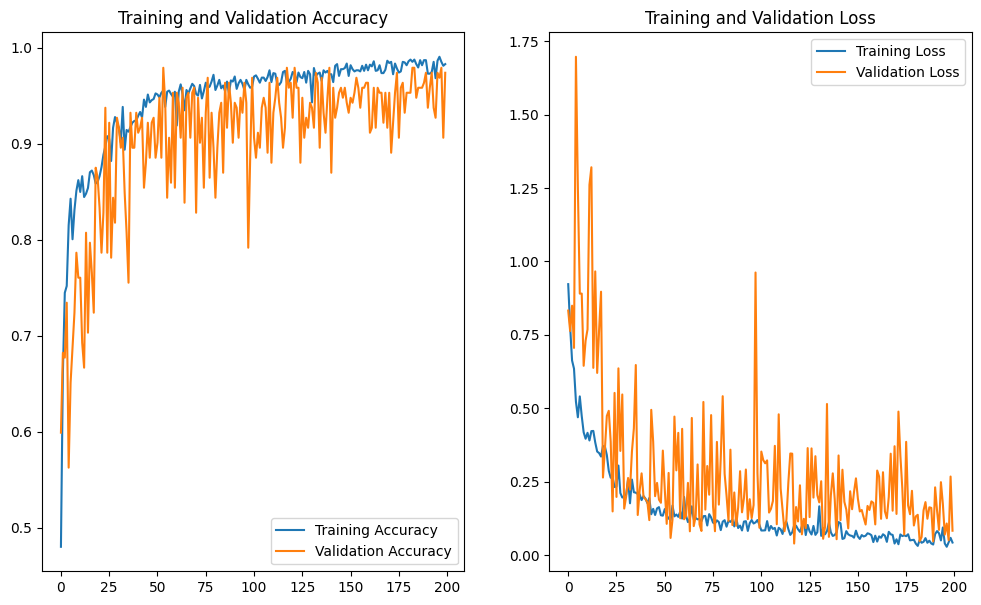

In [ ]:
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_acc)), train_acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
model1_32_DR4_001.save('/content/drive/My Drive/best_model1_32_DR4_001')

In [ ]:
# Model at Batch Size 32 and Learning Rate 0.01
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
model_32_DR4_01 = Sequential([
    resize_and_rescale,
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(3, activation='softmax')
])
model_32_DR4_01.build(input_shape = input_shape)
model_32_DR4_01.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
learning_rate = 0.01
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_32_DR4_01.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [ ]:
#Fit the model with training data and also pass validation data
history_32_DR4_01 = model_32_DR4_01.fit(
train_ds, epochs = 200, batch_size = Batch_Size, verbose = 1, validation_data = val_ds)

Epoch 1/200
54/54 [==============================] - 212s 622ms/step - loss: 0.9245 - accuracy: 0.5235 - val_loss: 0.8127 - val_accuracy: 0.6927
Epoch 2/200
54/54 [==============================] - 33s 602ms/step - loss: 0.7599 - accuracy: 0.6655 - val_loss: 0.5620 - val_accuracy: 0.8021
Epoch 3/200
54/54 [==============================] - 33s 616ms/step - loss: 0.7663 - accuracy: 0.6626 - val_loss: 0.6181 - val_accuracy: 0.7604
Epoch 4/200
54/54 [==============================] - 33s 610ms/step - loss: 0.6265 - accuracy: 0.7477 - val_loss: 0.5135 - val_accuracy: 0.8229
Epoch 5/200
54/54 [==============================] - 33s 606ms/step - loss: 0.6290 - accuracy: 0.7441 - val_loss: 0.5335 - val_accuracy: 0.8073
Epoch 6/200
54/54 [==============================] - 33s 602ms/step - loss: 0.5903 - accuracy: 0.7723 - val_loss: 0.6206 - val_accuracy: 0.7396
Epoch 7/200
54/54 [==============================] - 33s 602ms/step - loss: 0.5754 - accuracy: 0.7852 - val_loss: 0.5136 - val_accuracy

In [ ]:
# Getting the model history to analyse
train_loss = history_32_DR4_01.history['loss']
train_acc = history_32_DR4_01.history['accuracy']

val_loss = history_32_DR4_01.history['val_loss']
val_acc = history_32_DR4_01.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

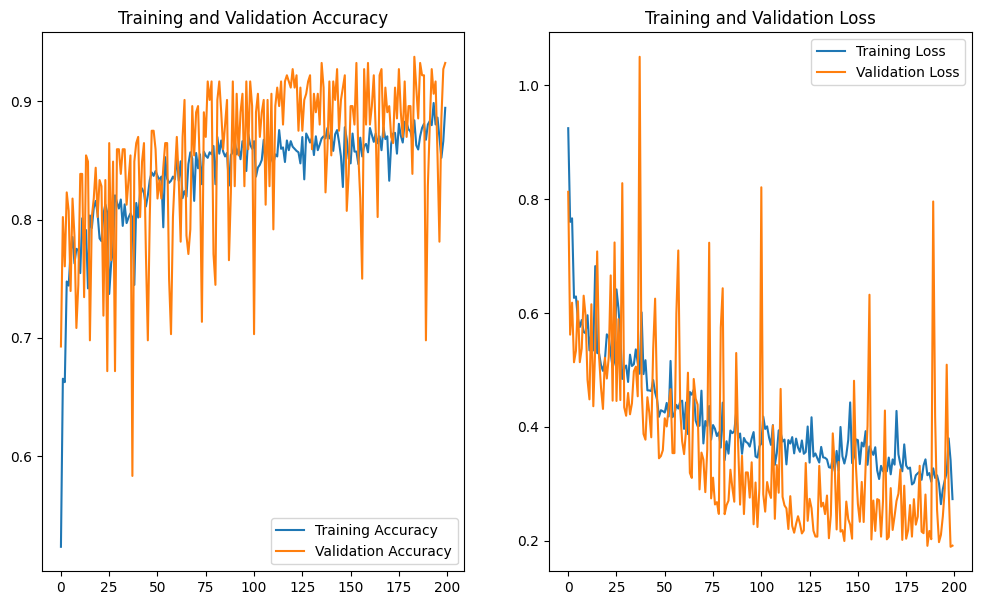

In [ ]:
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_acc)), train_acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')